### Image Transformation  
@author: N.Laanait  
@email: laanaitn@ornl.gov  
@date: 10/17/2016

This Notebook illustrates a straightforward workflow of using feature detection to register XRIM images.  
The main pyXRIM classes used are `FeatureExtraction` and `GeometricTransforms`.  
As things stand `FeatureExtraction` is a wrapper class over scikit-image orb detector.  
Sparse feature detectors will be implemented in the future and should be more apt at dealing with sparse xrim images.  

In [2]:
%matplotlib notebook
import numpy as np
import os
from matplotlib import pyplot as plt
import h5py as h5
from PyXRIM.PlotLib import imageGallery,imageTile
from PyXRIM.misc import TranslationTransform, RigidTransform 
from PyXRIM.FeatureExtraction import FeatureExtractor
from PyXRIM.GeometricTransforms import geoTransformer
from PyXRIM.Corrections import Corrector

In [3]:
# open h5file
wdir = os.getcwd()
fname = '/home/nl7/work/xray_data/BFO_TSO_20160330.hdf5'
fpath = os.path.join(wdir, fname)
f = h5.File(fpath, 'r')
f.items()
# Get Correction Files
metag = f['BFO_TSO_2/Meta']
READ = metag['READ']
DARK = metag['DARK']

In [18]:
raw = f['/BFO_TSO_2/Raw']
raw.items()
S001 = raw['S002']

In [23]:
S001.shape

(31, 2048, 2048)

In [3]:
#L-scan along [101]_pc near DSO 103_pc
rawg = f['BFO_TSO_2/Raw']
dset = rawg['S008']
dset.attrs['scan_command']
data = f[dset.attrs['registered']]
# L = dset.attrs['L']
# lscan_norm = f[dset.attrs['normalized']]
# lscan_flat = f[dset.attrs['flatfield']]
# Int_norm = np.mean(lscan_norm[:,800:1200,800:1200],axis=(1,-1))
# Int_flat = np.mean(lscan_flat[:,800:1200,800:1200],axis=(1,-1))

In [12]:
np.save('S008_fields.npy',dset.attrs['DAC5']*1e2/4.785)

In [7]:
np.save('S008_roi2.npy',data[:,800:1200,1000:1400])

<IPython.core.display.Javascript object>


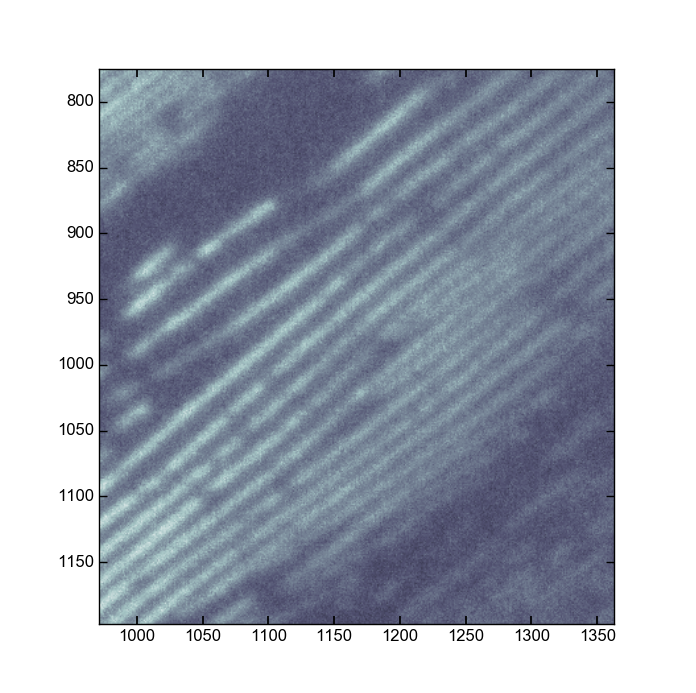

In [5]:
plt.figure()
plt.imshow(data[100],cmap='bone')

In [8]:
FE = FeatureExtractor('ORB', lib = 'skimage') 
FE.detector = FE.detector(n_keypoints=int(5e3)) 
FE.loadData(data)                      
keypts, desc= FE.getFeatures(processors = min(20,data.shape[0]), mask = True,
                              origin = [750, 650], window_size = 400)

launching 20 kernels...
Extracting features...
Closing down the kernels... 



In [9]:
# instantiate transformation class
gt = geoTransformer()
gt.loadData(data)
gt.loadFeatures([keypts, desc])

In [10]:
# find matches
matches, filt_matches = gt.matchFeatures(processors = 20, lib ='skimage',maximum_distance = 50)
[tmatch.shape for tmatch in filt_matches]

launching 20 kernels...
Extracting Matches From the Descriptors...
Closing down the kernels...



[(909, 2),
 (948, 2),
 (810, 2),
 (747, 2),
 (807, 2),
 (801, 2),
 (787, 2),
 (820, 2),
 (872, 2),
 (825, 2),
 (801, 2),
 (831, 2),
 (843, 2),
 (840, 2),
 (844, 2),
 (587, 2),
 (581, 2),
 (730, 2),
 (786, 2),
 (779, 2),
 (811, 2),
 (792, 2),
 (681, 2),
 (689, 2),
 (771, 2),
 (767, 2),
 (807, 2),
 (888, 2),
 (799, 2),
 (736, 2),
 (792, 2),
 (917, 2),
 (791, 2),
 (568, 2),
 (548, 2),
 (610, 2),
 (678, 2),
 (776, 2),
 (823, 2),
 (756, 2),
 (740, 2),
 (750, 2),
 (753, 2),
 (712, 2),
 (761, 2),
 (706, 2),
 (695, 2),
 (782, 2),
 (725, 2),
 (735, 2),
 (671, 2),
 (632, 2),
 (502, 2),
 (478, 2),
 (598, 2),
 (688, 2),
 (823, 2),
 (760, 2),
 (680, 2),
 (687, 2),
 (757, 2),
 (781, 2),
 (509, 2),
 (510, 2),
 (683, 2),
 (793, 2),
 (792, 2),
 (635, 2),
 (613, 2),
 (701, 2),
 (704, 2),
 (755, 2),
 (731, 2),
 (782, 2),
 (862, 2),
 (835, 2),
 (726, 2),
 (673, 2),
 (648, 2),
 (676, 2),
 (705, 2),
 (644, 2),
 (739, 2),
 (699, 2),
 (767, 2),
 (846, 2),
 (810, 2),
 (732, 2),
 (599, 2),
 (668, 2),
 (764, 2),

In [11]:
# find transformation based on matches
transforms, trueMatches = gt.findTransformation(TranslationTransform, matches, min(20,data.shape[0]), 
                                                min_samples = 4, residual_threshold = 2, 
                                                max_trials = int(1e5))
[np.where(tmatch == True)[0].size for tmatch in trueMatches]
[trans.translation for trans in transforms]

launching 20 kernels...
Extracting Inlier Matches with RANSAC...
Closing down the kernels...



[array([ 0.,  0.], dtype=float32),
 array([-1.,  0.], dtype=float32),
 array([ 0.,  0.], dtype=float32),
 array([-1.,  0.], dtype=float32),
 array([ 0., -1.], dtype=float32),
 array([-1., -1.], dtype=float32),
 array([ 1.,  1.], dtype=float32),
 array([ 0.,  0.], dtype=float32),
 array([-1.,  2.], dtype=float32),
 array([-1., -1.], dtype=float32),
 array([-1.,  1.], dtype=float32),
 array([ 0., -1.], dtype=float32),
 array([ 0.,  0.], dtype=float32),
 array([-1.,  0.], dtype=float32),
 array([ 1.,  0.], dtype=float32),
 array([ 1.,  0.], dtype=float32),
 array([-1.,  0.], dtype=float32),
 array([ 0., -1.], dtype=float32),
 array([ 0., -1.], dtype=float32),
 array([ 0.,  1.], dtype=float32),
 array([ 0., -1.], dtype=float32),
 array([-1.,  0.], dtype=float32),
 array([ 0.,  1.], dtype=float32),
 array([ 0., -1.], dtype=float32),
 array([ 0.,  0.], dtype=float32),
 array([-2.,  0.], dtype=float32),
 array([ 0.,  0.], dtype=float32),
 array([ 0.,  0.], dtype=float32),
 array([ 1.,  1.], d

In [12]:
# Reset transformations with not enough true matches (i.e inliers)
newTransforms = []
i = 0
for tmatch, trans in zip(trueMatches, transforms):
    i += 1
    if np.where(tmatch == True)[0].size < 4:
        trans = TranslationTransform(translation=(0,0))
        print('reseting transformation # %d!' %(i))
    newTransforms.append(trans)

In [13]:
# Transform images
transImages, chainTransforms = gt.applyTransformation(transforms,
                                      transformation ='translation')

Transforming Images...
Image #0
Image #1
Image #2
Image #3
Image #4
Image #5
Image #6
Image #7
Image #8
Image #9
Image #10
Image #11
Image #12
Image #13
Image #14
Image #15
Image #16
Image #17
Image #18
Image #19
Image #20
Image #21
Image #22
Image #23
Image #24
Image #25
Image #26
Image #27
Image #28
Image #29
Image #30
Image #31
Image #32
Image #33
Image #34
Image #35
Image #36
Image #37
Image #38
Image #39
Image #40
Image #41
Image #42
Image #43
Image #44
Image #45
Image #46
Image #47
Image #48
Image #49
Image #50
Image #51
Image #52
Image #53
Image #54
Image #55
Image #56
Image #57
Image #58
Image #59
Image #60
Image #61
Image #62
Image #63
Image #64
Image #65
Image #66
Image #67
Image #68
Image #69
Image #70
Image #71
Image #72
Image #73
Image #74
Image #75
Image #76
Image #77
Image #78
Image #79
Image #80
Image #81
Image #82
Image #83
Image #84
Image #85
Image #86
Image #87
Image #88
Image #89
Image #90
Image #91
Image #92
Image #93
Image #94
Image #95
Image #96
Image #97
Image #

In [19]:
f.close()

In [20]:
# Write data into h5-file
with h5.File(fpath, 'r+') as f:
    rawg = f['BFO_TSO_2/Raw']
    dset = rawg['S008']
    procg = f['BFO_TSO_2/Process']
    dsetname = 'S008_registered_ORB'
    dsetnew = procg.create_dataset(dsetname, data = transImages , dtype =np.float64,
                                    compression = 'lzf')
    dset.attrs['registered']=dsetnew.ref

In [17]:
np.save('S008_normalized_registered.npy',transImages)